#  Recruit Restaurant Forecasting

## Introduction

This is the implementation (jupyter notebook) of the Udacity Machine Learning Capstone Project. This project help many Japanese restaurants predicting how many customers to expect each day in the future. The forecasting won't be easy to make because many unexpected variables affect the visitor's judgment, for example, weather condition, preferences, date, popularity, etc.

There are several data that provided for this challange. The data comes from two separate companies and other sources:

* Hot Pepper Gourmet (hpg): Japan's gourmet site, here users can search restaurants and also make a reservation online on restaurant in japan.
* item AirREGI / Restaurant Board (air): A point of sales system specialized for Restaurant, can be used as reservation control and cash register system.

All of the is describe on below:

**air_reserve.csv** - This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

* `air_store_id` - the restaurant's id in the air system
* `visit_datetime` - the time of the reservation
* `reserve_datetime` - the time the reservation was made
* `reserve_visitors` - the number of visitors for that reservation

**hpg_reserve.csv** - This file contains reservations made in the hpg system.

* `hpg_store_id` - the restaurant's id in the hpg system
* `visit_datetime` - the time of the reservation
* `reserve_datetime` - the time the reservation was made
* `reserve_visitors` - the number of visitors for that reservation

**air_store_info.csv** - This file contains information about select air restaurants. Column names and contents are self-explanatory.
* `air_store_id`
* `air_genre_name`
* `air_area_name`
* `latitude`
* `longitude`

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs


**hpg_store_info.csv** - This file contains information about select hpg restaurants. Column names and contents are self-explanatory.
* `hpg_store_id`
* `hpg_genre_name`
* `hpg_area_name`
* `latitude`
* `longitude`
Note: latitude and longitude are the latitude and longitude of the area to which the store belongs


**store_id_relation.csv** - This file allows you to join select restaurants that have both the air and hpg system.
* `hpg_store_id`
* `air_store_id`

**air_visit_data.csv** - This file contains historical visit data for the air restaurants.
* `air_store_id`
* `visit_date` - the date
* `visitors` - the number of visitors to the restaurant on the date

**sample_submission.csv** - This file shows a submission in the correct format, including the days for which you must forecast.

* `id` - the id is formed by concatenating the air_store_id and visit_date with an underscore
* `visitors` - the number of visitors forecasted for the store and date combination

**date_info.csv** - This file gives basic information about the calendar dates in the dataset.

* `calendar_date`
* `day_of_week`
* `holiday_flg - is the day a holiday in Japan`

In [121]:
# Read all data from csv 
import os
import sys
import re
import glob
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from helper_function import *

%matplotlib inline

sns.set(color_codes=True)
sns.set_style('darkgrid')

data = {}
pattern = re.compile('(\w+).csv')
filenames = glob.glob('data/*.csv')

# laod data
for i in filenames:
    filename = pattern.search(i).group(1)
    data[filename] = pd.read_csv(i)

# print key data
for i in data.keys():
    print('key: %s' % i)

key: hpg_store_info
key: store_id_relation
key: air_store_info
key: sample_submission
key: date_info
key: air_reserve
key: air_visit_data
key: hpg_reserve


## Data Exploration

In [213]:
# Get Description for all data

from helper_function import DescriptionDF
from helper_function import transform_submission

# get store id from air and hpg
air_store_id = list(data['air_store_info']['air_store_id'].unique())
hpg_store_id = list(data['hpg_store_info']['hpg_store_id'].unique())
air_visit_id = list(data['air_visit_data']['air_store_id'].unique())

train_date_start = min(data['air_visit_data']['visit_date'])
train_date_end = max(data['air_visit_data']['visit_date'])

print('AIR VISIT DATA')
print('The min, max date: %s, %s' % (train_date_start, train_date_end))
print(DescriptionDF(data['air_visit_data']))

print('AIR STORE INFO')
print(DescriptionDF(data['air_store_info']))

print('AIR RESERVE')
print('The min, max reserve_datetime: %s, %s' % (min(data['air_reserve']['reserve_datetime']), max(data['air_reserve']['reserve_datetime'])))
print('The min, max visit_datetime: %s, %s' % (min(data['air_reserve']['visit_datetime']), max(data['air_reserve']['visit_datetime'])))
print(DescriptionDF(data['air_reserve']))

print('HPG STORE INFO')
print(DescriptionDF(data['hpg_store_info']))

print('HPG RESERVE')
print('The min, max reserve_datetime: %s, %s' % (min(data['hpg_reserve']['reserve_datetime']), max(data['hpg_reserve']['reserve_datetime'])))
print('The min, max visit_datetime: %s, %s' % (min(data['hpg_reserve']['visit_datetime']), max(data['hpg_reserve']['visit_datetime'])))
print(DescriptionDF(data['hpg_reserve']))

print('STORE RELATION')
print(data['store_id_relation'].count())
print('')

print('SUBMISSION DATA')
data['sample_submission']['air_store_id'] = data['sample_submission']['id'].apply(lambda rows: transform_submission(rows)[0])
data['sample_submission']['visit_date'] = data['sample_submission']['id'].apply(lambda rows: transform_submission(rows)[1])
data['sample_submission'].drop('id', axis=1, inplace=True)  # drop the id column
print('The min, max date: %s, %s' % (min(data['sample_submission']['visit_date']), max(data['sample_submission']['visit_date'])))
print(DescriptionDF(data['sample_submission']))


AIR VISIT DATA
The min, max date: 2016-01-01, 2017-04-22
Total Column: 3
Total Row: 252108
+--------------+--------+------------+----------+---------------+---------------+---------------+
| Column_Name  |  Type  | Unique_val | Null_val |    Min_val    |    Mean_val   |    Max_val    |
+--------------+--------+------------+----------+---------------+---------------+---------------+
| air_store_id | object |    829     |    0     | Not Float/Int | Not Float/Int | Not Float/Int |
|  visit_date  | object |    478     |    0     | Not Float/Int | Not Float/Int | Not Float/Int |
|   visitors   | int64  | Not Object |    0     |      1.0      |    20.97376   |     877.0     |
+--------------+--------+------------+----------+---------------+---------------+---------------+

AIR STORE INFO
Total Column: 5
Total Row: 829
+----------------+---------+------------+----------+---------------+---------------+---------------+
|  Column_Name   |   Type  | Unique_val | Null_val |    Min_val    |    Mea

In [261]:
print('Total of restaurant in AirRegi store info: ', len(air_store_id))
print('Total of restaurant in HPG store info: ', len(hpg_store_id))
print('Total of restaurant in AirRegi visit data: ', len(air_visit_id))

('Total of restaurant in AirRegi store info: ', 829)
('Total of restaurant in HPG store info: ', 4690)
('Total of restaurant in AirRegi visit data: ', 829)


We can see on the graph below, In air_visit_data, not all restaurant contains historical visit from 2016-01-01 (1st January 2016) to 2017-04-22 (22th April 2017), but most of them available start on July 2016. This is explain the sudden increase of total visitors that happen on July 2016. Also because we need one day period data, there are some missing value per-day in some restaurants. We may fill the missing values.

During January-December there was a sharp increase in average of visitors  and then after that it quickly fell down. Maybe this is due to people celebrate holiday(e.g christmas) or End of Month and then some restaurant closed because of end of month, caused the chart from went up to down quickly.

Usually, there are some small peak when holiday comes. People tends to go to restaurant when holiday.

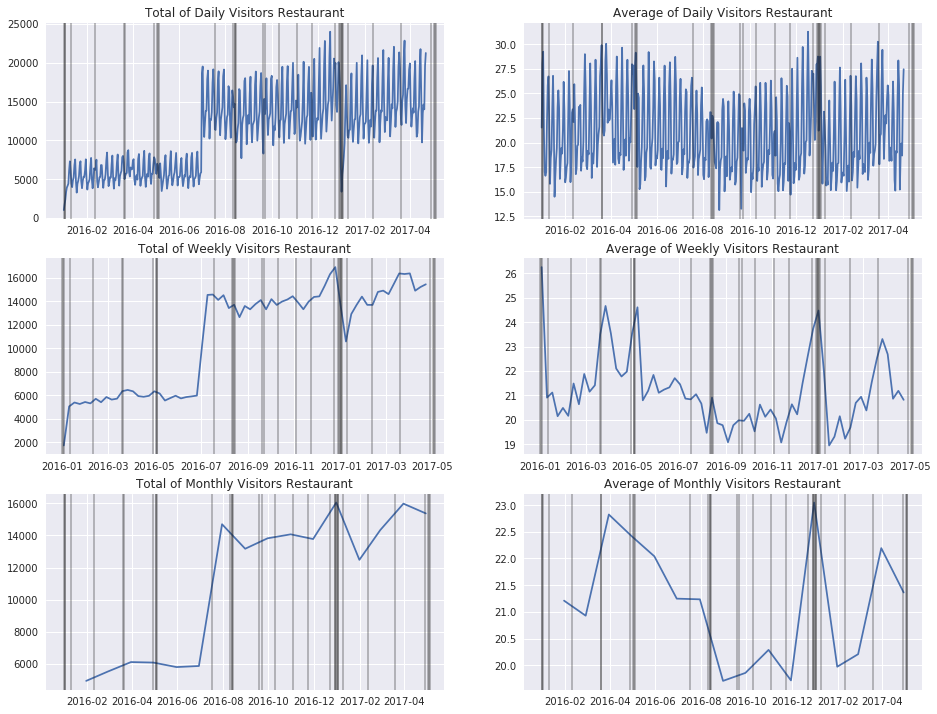

In [8]:
sns.set(color_codes=True)
sns.set_style('darkgrid')

# sum visitor for all restaurant per data
all_restaurant_visitors = data['air_visit_data'].groupby(['visit_date']).agg(['mean', 'sum']).reset_index()
all_restaurant_visitors['visit_date'] = pd.to_datetime(all_restaurant_visitors['visit_date'])
all_restaurant_visitors = all_restaurant_visitors.set_index('visit_date')

fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]]= plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(15.7, 12.27)

# daily
ax1.plot(all_restaurant_visitors['visitors']['sum'])
ax1.set_title('Total of Daily Visitors Restaurant')

ax2.plot(all_restaurant_visitors['visitors']['mean'])
ax2.set_title('Average of Daily Visitors Restaurant')

# weekly
ax3.plot(all_restaurant_visitors['visitors']['sum'].resample('W').mean())
ax3.set_title('Total of Weekly Visitors Restaurant')
ax4.plot(all_restaurant_visitors['visitors']['mean'].resample('W').mean())
ax4.set_title('Average of Weekly Visitors Restaurant')

# monthly
ax5.plot(all_restaurant_visitors['visitors']['sum'].resample('M').mean())
ax5.set_title('Total of Monthly Visitors Restaurant')
ax6.plot(all_restaurant_visitors['visitors']['mean'].resample('M').mean())
ax6.set_title('Average of Monthly Visitors Restaurant')

# add Holiday date to the chart
for x in data['date_info'].query('holiday_flg==1').index:
    vline_id = data['date_info']['calendar_date'].loc[x]
    ax1.axvline(x=vline_id, color='k', alpha = 0.3)
    ax2.axvline(x=vline_id, color='k', alpha = 0.3)
    ax3.axvline(x=vline_id, color='k', alpha = 0.3)
    ax4.axvline(x=vline_id, color='k', alpha = 0.3)
    ax5.axvline(x=vline_id, color='k', alpha = 0.3)
    ax6.axvline(x=vline_id, color='k', alpha = 0.3)

Text(0.5,1,u'Median of Visitors Restaurant in Month')

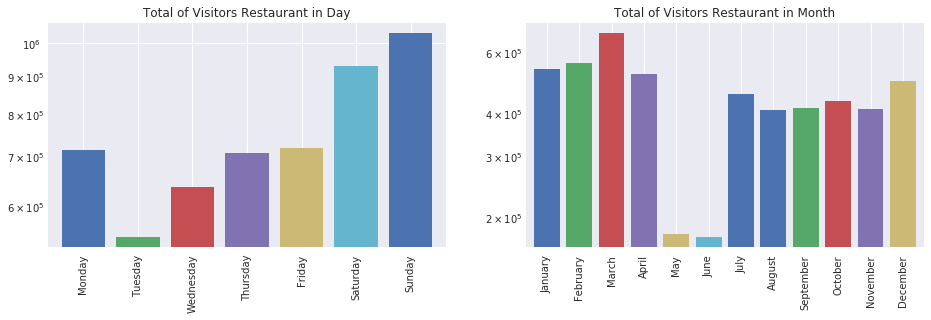

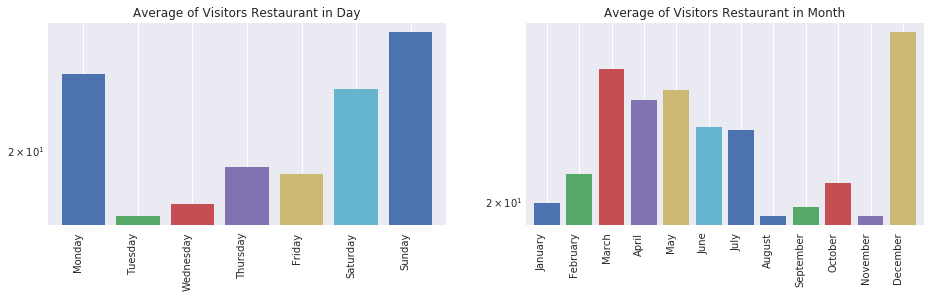

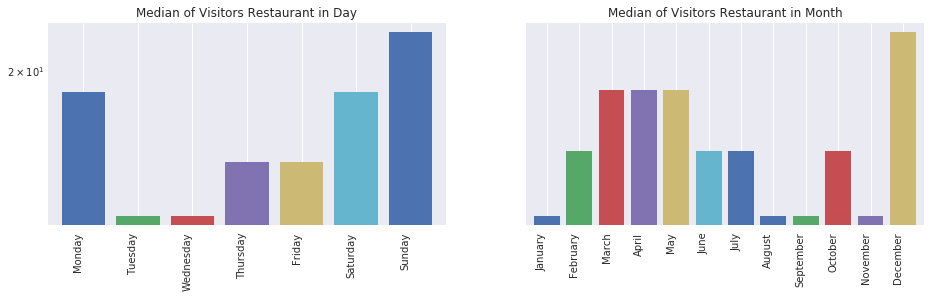

In [9]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

seasonal_restaurant_visitors = data['air_visit_data'].copy(deep=True)
seasonal_restaurant_visitors['visit_date'] = pd.to_datetime(seasonal_restaurant_visitors['visit_date'])
seasonal_restaurant_visitors = seasonal_restaurant_visitors.set_index('visit_date')

datetime_idx = pd.Series(seasonal_restaurant_visitors.index)
seasonal_restaurant_visitors['day'] = list(datetime_idx.apply(lambda row: row.strftime('%A')))
seasonal_restaurant_visitors['day_num'] = list(datetime_idx.apply(lambda row: row.strftime('%w')))
seasonal_restaurant_visitors['month'] = list(datetime_idx.apply(lambda row: row.strftime('%B')))
seasonal_restaurant_visitors['month_num'] = list(datetime_idx.apply(lambda row: row.strftime('%m')))

visitors_in_day = seasonal_restaurant_visitors.groupby(['day', 'day_num']).agg(['sum', 'mean', 'median']).reset_index()
visitors_in_day = visitors_in_day.set_index('day_num').sort_index()
visitors_in_month = seasonal_restaurant_visitors.groupby(['month', 'month_num']).agg(['sum', 'mean', 'median']).reset_index()
visitors_in_month = visitors_in_month.set_index('month_num').sort_index()

fig1, [ax1, ax2] = plt.subplots(ncols=2)
fig1.set_size_inches(15.7, 4.135)

fig2, [ax3, ax4] = plt.subplots(ncols=2)
fig2.set_size_inches(15.7, 4.135)
fig2.autofmt_xdate() # make x-axis skew

fig3, [ax5, ax6] = plt.subplots(ncols=2)
fig3.set_size_inches(15.7, 4.135)
fig3.autofmt_xdate() # make x-axis skew

# Day
ax1.set_yscale('log')
pd.Series(list(visitors_in_day['visitors']['sum']), index=weekday).plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Total of Visitors Restaurant in Day')

# Month
ax2.set_yscale('log')
pd.Series(list(visitors_in_month['visitors']['sum']), index=month).plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Total of Visitors Restaurant in Month')

# Day
ax3.set_yscale('log')
pd.Series(list(visitors_in_day['visitors']['mean']), index=weekday).plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Average of Visitors Restaurant in Day')

# Month
ax4.set_yscale('log')
pd.Series(list(visitors_in_month['visitors']['mean']), index=month).plot(kind='bar', ax=ax4, width=0.8)
ax4.set_title('Average of Visitors Restaurant in Month')

# Day
ax5.set_yscale('log')
pd.Series(list(visitors_in_day['visitors']['median']), index=weekday).plot(kind='bar', ax=ax5, width=0.8)
ax5.set_title('Median of Visitors Restaurant in Day')

# Month
ax6.set_yscale('log')
pd.Series(list(visitors_in_month['visitors']['median']), index=month).plot(kind='bar', ax=ax6, width=0.8)
ax6.set_title('Median of Visitors Restaurant in Month')

Interestingly, Tuesday is least busy day for restaurant not Monday. Usually it will increase each day until Sunday where the peak is reached. Monday is ranked at three for the busiest day, followed by Saturday and then Sunday.

On average, December is the busiest month. For January, August, September and November they are the least busy months. May and June have the least on total visitors because the data is not available as stated before.

In [10]:
hpg_store_data = data['hpg_store_info'].merge(data['store_id_relation'], on='hpg_store_id')
hpg_store_data = data['air_visit_data'].merge(hpg_store_data, on='air_store_id')
hpg_store_genre = list(hpg_store_data['hpg_genre_name'].unique())
print("HPG restaurant genre type: %s \n" % hpg_store_genre)

air_store_data = data['air_visit_data'].merge(data['air_store_info'], on='air_store_id')
air_store_genre = list(air_store_data['air_genre_name'].unique())
print("AIR restaurant genre type: %s" % air_store_genre)

combine_store_hpg = data['hpg_store_info'].merge(data['store_id_relation'], on='hpg_store_id', how='inner')
combine_hpg_hpg_air = combine_store_hpg.merge(data['air_store_info'], on='air_store_id')
combine_hpg_hpg_air.head()

HPG restaurant genre type: ['International cuisine', 'Party', 'Creation', 'Spain Bar/Italian Bar', 'Japanese style', 'Italian', 'Grilled meat', 'Okonomiyaki/Monja/Teppanyaki', 'Seafood', 'Steak/Hamburger/Curry', 'Cafe', 'Japanese food in general', 'Amusement bar', 'Karaoke', 'Creative Japanese food', 'Japanese cuisine/Kaiseki'] 

AIR restaurant genre type: ['Dining bar', 'Izakaya', 'Cafe/Sweets', 'Bar/Cocktail', 'Italian/French', 'Okonomiyaki/Monja/Teppanyaki', 'Other', 'International cuisine', 'Japanese food', 'Yakiniku/Korean food', 'Karaoke/Party', 'Western food', 'Creative cuisine', 'Asian']


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_x,longitude_x,air_store_id,air_genre_name,air_area_name,latitude_y,longitude_y
0,hpg_cac091abfcee2a85,Japanese style,Tōkyō-to Chūō-ku Ginza,35.668600,139.763043,air_2aab19554f91ff82,Yakiniku/Korean food,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825
1,hpg_e87d00be48cd91c6,Japanese style,Tōkyō-to Sumida-ku Tachibana,35.704960,139.828642,air_258ad2619d7bff9a,Izakaya,Tōkyō-to Kōtō-ku Tōyō,35.672853,139.817410
2,hpg_03795a62e1c5f1c3,Japanese style,Hiroshima-ken Hiroshima-shi Hondōri,34.392106,132.461914,air_c47aa7493b15f297,Izakaya,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018
3,hpg_51fab1683266cd55,Japanese style,Ōsaka-fu Ōsaka-shi Shinsaibashisuji,34.669514,135.501425,air_96005f79124e12bf,Izakaya,Ōsaka-fu Ōsaka-shi Nanbasennichimae,34.664744,135.503444
4,hpg_9668001cf2b8dc74,Japanese style,Tōkyō-to Taitō-ku None,35.711353,139.782684,air_f2c5a1f24279c531,Japanese food,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996


Total restaurants that available by using HPG is 4690 and for AirRegi about 829 restaurants. By seeing store_id_relation data, only 150 restaurants that use both AirREGI and HPG. But when we merge it into air_store_info and hpg_store_info data, just 63 restaurants that can be explained (see the area, latlng and genre). Also, both HPG and AirRegi have a different way of categorizing the restaurant genre and the latlng is not exactly the same, so we may analyze it separately.

Japanese style is the most common restaurant on Japan and usually have izakaya style. Asian restaurant (like Taiwanese, Thai,  and Shanghai) is rarely seen in Japan but interestingly is the most popular restaurants followed by Karaoke/Party and Izakaya. So Izakaya is not only common but also popular.


Text(0,0.5,u'')

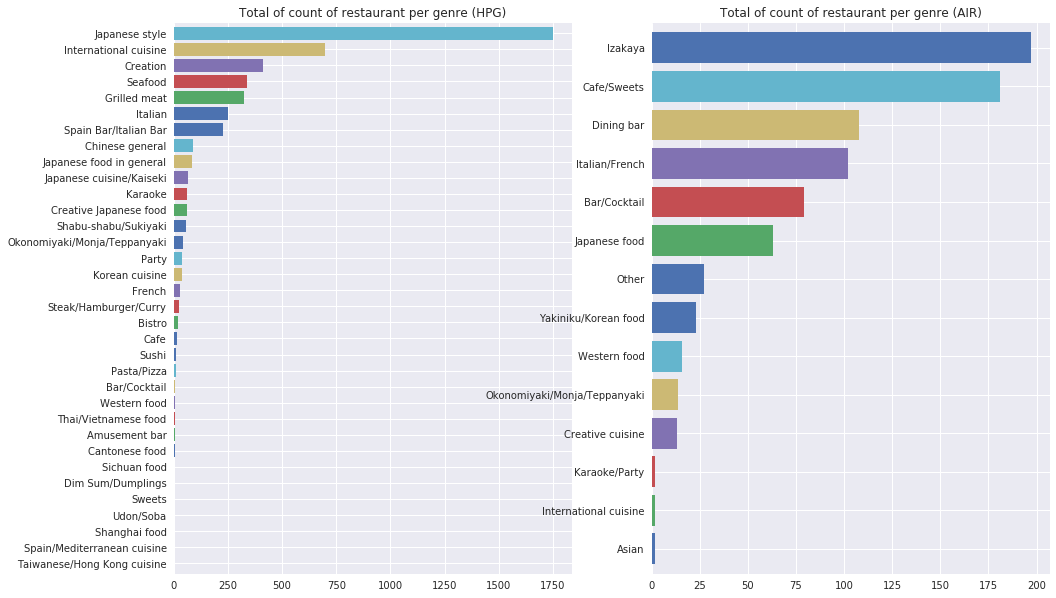

In [11]:
hpg_genre_cat = data['hpg_store_info'].groupby(['hpg_genre_name'])['hpg_store_id'].count().sort_values()
air_genre_cat = data['air_store_info'].groupby(['air_genre_name'])['air_store_id'].count().sort_values()

fig1, [ax1, ax2] = plt.subplots(ncols=2)
fig1.set_size_inches(15.7, 10.135)

# ax1.set_yscale('log')
hpg_genre_cat.plot(kind='barh', ax=ax1, width=0.8)
ax1.set_title('Total of count of restaurant per genre (HPG)')
ax1.set_ylabel('')

# ax2.set_yscale('log')
air_genre_cat.plot(kind='barh', ax=ax2, width=0.8)
ax2.set_title('Total of count of restaurant per genre (AIR)')
ax2.set_ylabel('')

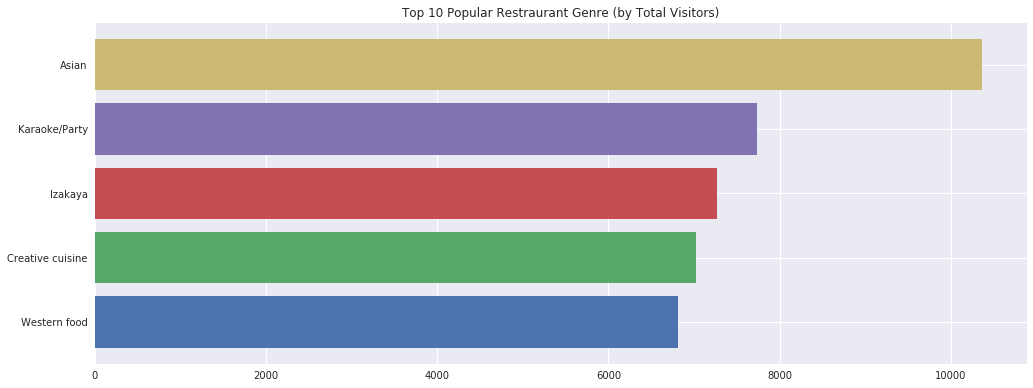

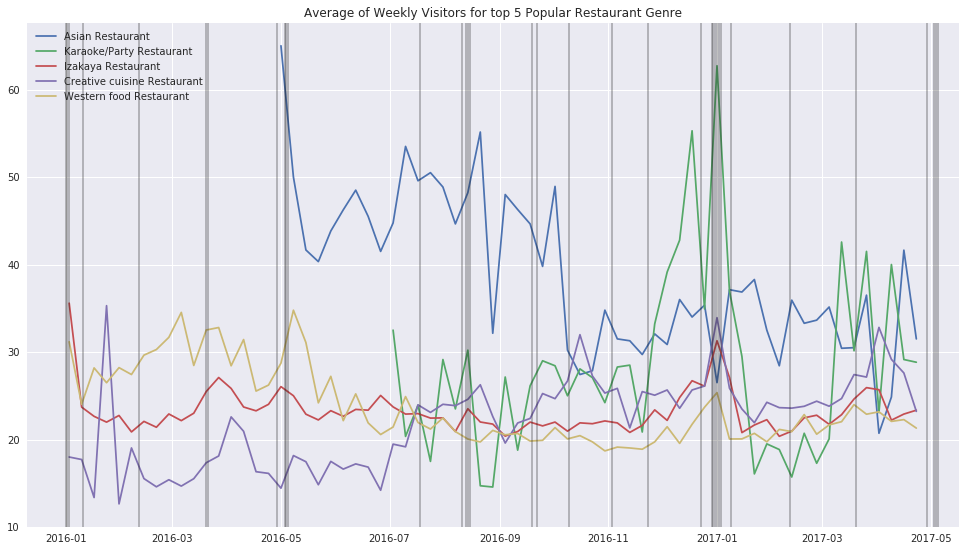

In [12]:
visitors_per_genre = air_store_data.groupby(['air_store_id', 'air_genre_name']).sum().reset_index()

top_restraurant_genre = visitors_per_genre.groupby(['air_genre_name']).mean().reset_index().sort_values(['visitors'], ascending=0)
top_restraurant_genre = top_restraurant_genre.set_index('air_genre_name')

fig1, ax1 = plt.subplots(nrows=1)
fig1.set_size_inches(16.7, 6.27)

fig2, ax2 = plt.subplots(nrows=1)
fig2.set_size_inches(16.7, 9.27)

n_restaurant = 5
# ax2.set_yscale('log')
top_restraurant_genre['visitors'].head(n_restaurant).sort_values().plot(kind='barh', ax=ax1, width=0.8)
ax1.set_title('Top 10 Popular Restraurant Genre (by Total Visitors)')
ax1.set_ylabel('')

visitors_per_genre_ts = air_store_data.groupby(['visit_date', 'air_genre_name']).mean().reset_index()
visitors_per_genre_ts['visit_date'] = pd.to_datetime(visitors_per_genre_ts['visit_date'])
visitors_per_genre_ts = visitors_per_genre_ts.set_index('visit_date')

legend_name = []
for i in list(top_restraurant_genre['visitors'].head(n_restaurant).index):
    legend_name.append('{} Restaurant'.format(i))
    df = filter_by_column(visitors_per_genre_ts, 'air_genre_name', i, 'eq')['visitors']
    ax2.plot(df.resample('W').mean())

# add Holiday date to the chart
for x in data['date_info'].query('holiday_flg==1').index:
    vline_id = data['date_info']['calendar_date'].loc[x]
    ax2.axvline(x=vline_id, color='k', alpha = 0.3)
ax2.set_title('Average of Weekly Visitors for top {} Popular Restaurant Genre'.format(n_restaurant))
legend = ax2.legend(legend_name, loc='upper left', shadow=True)

### Reservation Data

Because there are restaurants that have both AirREGI and HPG, we need to check if both of them have same reservation data. When they have different values, we choose the bigger values.

In [13]:
def split_date(rows):
    datetime = rows.split(' ')    
    return datetime[0], datetime[1]

def same_reservation(reserve_air, reserve_hpg):
    ''' check if hpg and air have same reservation data'''
    if reserve_air == reserve_hpg:
        return 1
    return 0

def get_reserve(reserve_air, reserve_hpg):
    ''' get total_reservation from air and hpg data'''
    if pd.isnull(reserve_air) and not pd.isnull(reserve_hpg):
        return reserve_hpg
    elif not pd.isnull(reserve_air) and pd.isnull(reserve_hpg):
        return reserve_air
    elif not pd.isnull(reserve_air) and not pd.isnull(reserve_hpg):
        if reserve_air >= reserve_hpg:
            return reserve_air
        return reserve_hpg
    return 0

In [14]:
# merge hpg reserve to store_id_relation
hpg_reserve_data = data['hpg_reserve'].merge(data['store_id_relation'], on='hpg_store_id', how='inner' )
hpg_reserve_data.rename(columns={'reserve_visitors':'reserve_visitors_hpg'}, inplace=True)

# merge hpg_reserve_data to air_reserve by air_store_id, visit_datetime and reserverse_datetime
air_reserve_data = data['air_reserve'].copy(deep=True)
air_reserve_data.rename(columns={'reserve_visitors':'reserve_visitors_air'}, inplace=True)
total_reserve_data = hpg_reserve_data.merge(air_reserve_data, on=['air_store_id', 'reserve_datetime', 'visit_datetime'], how='outer')
same_reservation_data = total_reserve_data.loc[pd.notnull(total_reserve_data.reserve_visitors_hpg) & pd.notnull(total_reserve_data.reserve_visitors_air)]

In [15]:
# Check the reservation value between air and hpg
# There are 4569 data that have same reservation values between air and hpg
same_reservation_data['same_reservation'] = same_reservation_data.apply(lambda cols: same_reservation(cols['reserve_visitors_air'], cols['reserve_visitors_hpg']), axis=1)
same_reservation_data['same_reservation'].value_counts()

/home/ec2-user/anaconda3/envs/python3/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


1    4569
0     171
Name: same_reservation, dtype: int64

In [16]:
total_reserve_data['total_reserve_visitors'] = total_reserve_data.apply(lambda cols: get_reserve(cols['reserve_visitors_air'], cols['reserve_visitors_hpg']), axis=1)
total_reserve_data['visit_date'] = total_reserve_data['visit_datetime'].apply(lambda rows: split_date(rows)[0])
total_reserve_data = total_reserve_data.groupby(['air_store_id', 'visit_date']).sum().reset_index()

# About 333 restaurant have reservation data while 500 other restaurants don't have any information on reservations
print('Total restaurant that have reservation data: %s' % len(total_reserve_data['air_store_id'].unique()))
print('Total restaurant in air_visit_data: %s' % len(data['air_visit_data']['air_store_id'].unique()))

Total restaurant that have reservation data: 333
Total restaurant in air_visit_data: 829


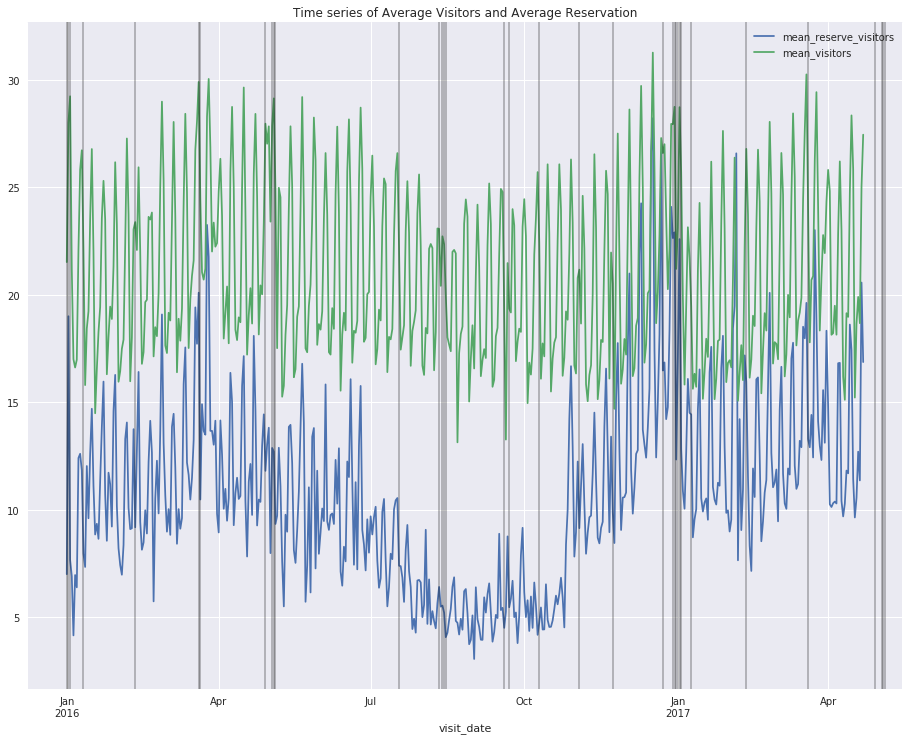

In [17]:
# merge total_reserve_visitors to air_visit_data
air_visit_reserve = data['air_visit_data'].merge(total_reserve_data, on=['air_store_id', 'visit_date'], how='left')
air_visit_reserve = air_visit_reserve.drop(columns=['reserve_visitors_hpg', 'reserve_visitors_air'])

fig, ax = plt.subplots(nrows=1)
fig.set_size_inches(15.7, 12.27)

air_visit_reserve_mean = air_visit_reserve.groupby('visit_date').mean().reset_index().rename(columns={'visitors': 'mean_visitors', 'total_reserve_visitors': 'mean_reserve_visitors'})
air_visit_reserve_mean = air_visit_reserve_mean.set_index(pd.to_datetime(air_visit_reserve_mean['visit_date']))

# ax.set_title('Total of Daily Visitors Restaurant')
air_visit_reserve_mean[['mean_reserve_visitors', 'mean_visitors']].plot(ax=ax, use_index=True, title='Time series of Average Visitors and Average Reservation')

# add holiday date
for x in data['date_info'].query('holiday_flg==1').index:
    vline_id = data['date_info']['calendar_date'].loc[x]
    ax.axvline(x=vline_id, color='k', alpha = 0.3)

We need to check the correlation between visitors and the reservation made. We can see result on the below, correlation between mean reserve visitors and mean visitors is `0.59690`. We can see from this stats, the reservations value tend to follow the visitors value. 

If we use rolling correlation rather than just correlation, the correlation between both data is much clearer. Correlation is higher and stable on December-January, it means people tends only to reserve when it comes to holiday.

In [18]:
# correlation between mean reservation made and mean visitors
air_visit_reserve_mean[['mean_reserve_visitors', 'mean_visitors']].corr(method='pearson')

,mean_reserve_visitors,mean_visitors
mean_reserve_visitors,1.000000,0.596904
mean_visitors,0.596904,1.000000


/home/ec2-user/anaconda3/envs/python3/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30).corr(other=<Series>)
  from ipykernel import kernelapp as app


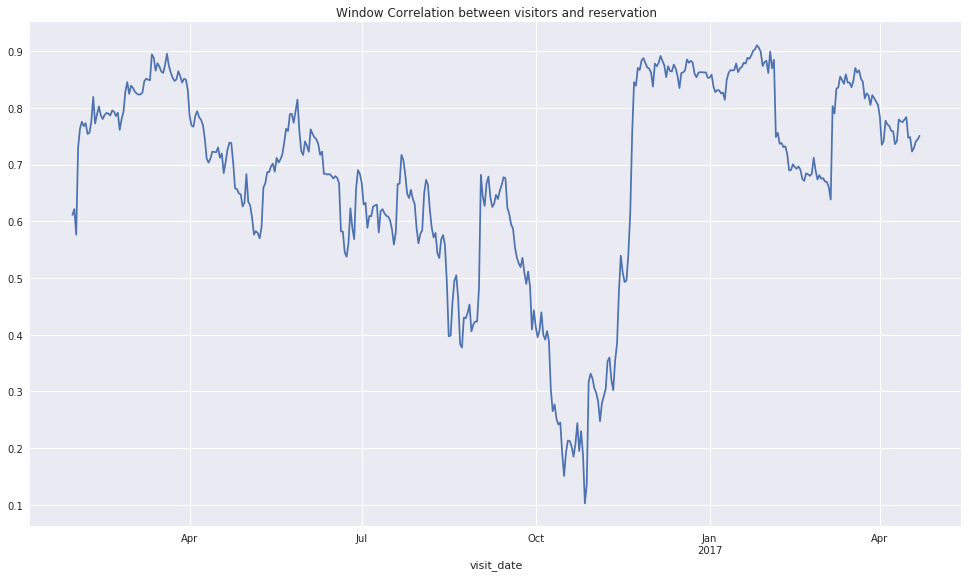

In [19]:
# Rolling Correlation between mean visitors and mean reservation
pd.rolling_corr(air_visit_reserve_mean['mean_reserve_visitors'], air_visit_reserve_mean['mean_visitors'], window=30).plot(title="Window Correlation between visitors and reservation", figsize=(16.7, 9.27))

### Spatial Map

In [4]:
import folium
import vincent

sys.path.append('/home/ec2-user/SageMaker/Dimas')

def coordinate(df):
    ''' create unique keys from lat and lng '''
    return '{}+{}'.format(round(df['latitude'], 6), round(df['longitude'], 6))

def reverse_coor(coordinate):
    lat_lng = coordinate.split('+')
    return [float(lat_lng[0]), float(lat_lng[1])]

In [23]:
# japan latitude and longitude
lat, lng = 35.652832, 139.839478

x = data['air_store_info'].copy()
x.insert(5, 'coordination', data['air_store_info'].apply(coordinate, axis=1))

# Multiple restaurant can be represent by one coordinate
air_genres = x.groupby(['coordination', 'air_area_name', 'air_genre_name'])['air_store_id'].count().reset_index()
index_coor = list(air_genres['coordination'].unique())
index_area = list(air_genres['air_area_name'].unique())

restaurant_map = folium.Map( [lat, lng], zoom_start=6)

# The Restaurant by Cordinate
def bar_vincent(df, x_value='Restaurant'):
    bar = vincent.GroupedBar(pd.DataFrame.from_dict([dict(df)]))
    bar.axis_titles(x=x_value, y='count')
    bar.height = 200
    bar.width = 300
    bar.colors(brew='Set3')
    bar.legend(title='Restaurant Genre')
    return bar.to_json()

for index, res_coor in enumerate(index_coor):    
    area = filter_by_column(air_genres, 'coordination', res_coor, 'eq')
    area_name = list(area['air_area_name'])[0]
    rest_area = area.pivot(index='coordination', columns='air_genre_name', values='air_store_id')
    lat_lng = reverse_coor(list(rest_area.index)[0])
    
    bar_data = bar_vincent(rest_area, area_name)
    mark = folium.map.Marker(
        location=lat_lng, 
        popup = folium.Popup(max_width=450).add_child(
            folium.Vega(bar_data, width=450, height=250))
        ).add_to(restaurant_map)

restaurant_map

## Approach

There is some pattern found by using historical data, this means the visitor's data also depends on historical data (time dependent). Because of this properties, there are various steps involved to forecast the visitors. We can only use historical data without another feature (univariate) or even just external features without past values. In general, There are two approaches for forecasting visitors in all restaurants:

* Statistical approach: Forecast per-restaurant only by using trend, seasonal and cyclic pattern in historical data. We can use univariate ARIMA for this kind of approach.
*  Machine Learning approach: Forecast by using supervised learning with features like date-related, time-related, location-related, weather, etc.

The goals for the challange is forecast the number of visitors for each `air_store_id` from **2016-12-24** to **2017-04-22**

The submission are evaluate on the **RMSLE**:

$$\sqrt{ \frac{1}{N} \sum_{i=1}^{n} (log(P_i + 1) - log(\alpha_i + 1))^2 }$$

where:

* $n$ is the total number of observations 
* $P_i$ is your prediction of visitors
* $\alpha_i$ is the actual number of visitors 
* $log⁡(x)$ is the natural logarithm of x


In [26]:
def score_rmsle(target, predict):
    ''' prediction is the prediction number of visitors
        target  is the actual number of visitors
    '''
    return np.sqrt( np.square(np.log(predict + 1) - np.log(target + 1)).mean() )

Before modeling the data, usually, we split the data into training and testing dataset to evaluate models we built. Evaluating time series data is different than what we usually do, this is because we assume that there is no relationship between observation (independent). This is not true for time series because time-series data depends on past data we cannot split data randomly. In order to fix this, we split data and respect the temporal order which the data observed. In time-series, evaluate models based on historical data called **`backtesting`**.

In [178]:
from sklearn.model_selection import TimeSeriesSplit

def train_test_split(df):
    ''' split train and test data '''
    tscv = TimeSeriesSplit(n_splits=3)  # split into 3
    index_train_test = {1: {}, 2:{}, 3:{}}
    i = 1
    for train_index, test_index in tscv.split(df):
        index_train_test[i]['train'] = (min(train_index), max(train_index))
        index_train_test[i]['test'] = (min(test_index), max(test_index))
        i += 1
    return index_train_test

def reindex_time(df, cols='visitors'):
    ''' reindex data with datetime as the index and frequency in Day '''
    start_date = '2016-01-13'
    end_date = '2017-04-22'
    df['visit_date'] = pd.to_datetime(df['visit_date'])    
    df = df.set_index('visit_date')
    df = df.asfreq('D').interpolate(method='pchip')  # performs linear interpolation at missing datapoint        
    df[cols] = df[cols].apply(lambda rows: round(rows, 0))  # round the interpolation values
    return df  

# get random sample
random.seed(101)
random_air_id = random.sample(air_store_id, 1)

random_restaurant = filter_store_id(data['air_visit_data'], 'air_store_id', random_air_id)
random_restaurant = reindex_time(random_restaurant)['visitors']

# split train and test data
split_dict = train_test_split(random_restaurant)
random_restaurant_train = random_restaurant[split_dict[3]['train'][0]:split_dict[3]['train'][1]]
random_restaurant_test = random_restaurant[split_dict[3]['train'][1]-1:split_dict[3]['test'][1]+1]

# split train and test data by date
date_test = random_restaurant.index[split_dict[3]['train'][1]-1:split_dict[3]['test'][1]+1]

In [179]:
print(min(random_restaurant_train.index), max(random_restaurant_train.index))
print(min(random_restaurant_test.index), max(random_restaurant_test.index))

(Timestamp('2016-01-05 00:00:00', freq='D'), Timestamp('2016-12-24 00:00:00', freq='D'))
(Timestamp('2016-12-24 00:00:00', freq='D'), Timestamp('2017-04-22 00:00:00', freq='D'))


### Statistical Approach

ARIMA models is one the common method that used in time series forecasting, which stands for **A**utoreg**R**essive **I**ntegrated **M**oving **A**verage. ARIMA models aim to describe the autocorreations in the data$^{[3]}$.

ARIMA models in denoted with notation ARIMA(p, d, q), it consist of three component and used to parameterize the models. that is:

**Autoregressive (AR)** denote by *p*

AR assumes that the present value of a time series can be explained as a function of its past values, the function is constructed using a linear combination of *past values of the variable with lag p or dependent on p past values*. The term *autoregression* indicates that it is a regression of the variable against itself. The $y_t$ is stationary, Autoregrssive model of order p or AR(p) can be written:

$$y_t = c + \Phi_1 y_{t-1} + \Phi_2 y_{t-2} + \Phi_3 y_{t-3} + ... + \Phi_p y_{t-p} + e_t$$

**Integrated (I)** denote by *d*

Compute the differences between consecutive observations. This is known as differencing. Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality. I(d) for the first third order is:

No Differencing (d=0):  $y_t  =  y_t$

First Differencing (d=1):  $y_t  =  y_t - y_{t-1}$

Second Differencing (d=2):  $y_t  =  y_t - 2y_{t-1} + y_{t-2}$


**Moving Average (MA)** denote by *q*

MA models use past errors variables for forecasting in a regression-like model (like weighted moving average of the past few error). *It is dependent on q past error terms or lag q on past error*. The $y_t$ is stationary, so moving average model of order q, MA(q) can be written as:

$$y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \theta_3 e_{t-3} + ... + \theta_p e_{t-q}$$

The combination of differencing with autoregression and moving average model, this is called *non-seasonal ARIMA model*. The full model can be written as:

$$y'_t = c + e_t + \theta_1 e_{t-1} + ... + \theta_p e_{t-q} +\Phi_1 y'_{t-1} + ... + \Phi_p y'_{t-p}  $$

When a time series data with seasonal effects, we use another model called *seasonal* ARIMA or SARIMA, which is denoted as ARIMA(p, d, q)(P, D, Q)s where (P, D, Q) is seasonal parameters and `s` is the periodicity of the time series.

In [128]:
# Function for Time Series plotting and Prediction

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import itertools
import logging
import warnings

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# ARIMA parameter that invalid
param_error = [
 '(0, 0, 0)x(0, 0, 0, 7)', '(0, 0, 0)x(0, 1, 0, 7)', '(0, 0, 0)x(0, 2, 0, 7)', 
 '(0, 1, 0)x(0, 0, 0, 7)', '(0, 1, 0)x(0, 1, 0, 7)', '(0, 1, 0)x(0, 2, 0, 7)', 
 '(0, 2, 0)x(0, 0, 0, 7)', '(0, 2, 0)x(0, 1, 0, 7)', '(0, 2, 0)x(0, 2, 0, 7)'
]

def arima_fit(df, param, seasonal_param, exog=None, trend=None):
    ''' fit ARIMA model '''
    mod = sm.tsa.statespace.SARIMAX(df,
                                    exog=exog,
                                    trend=trend,
                                    order=param, 
                                    seasonal_order=seasonal_param,
                                    enforce_stationarity=False,  #  Whether or not to transform the AR parameters to enforce stationarity in the autoregressive component of the model
                                    enforce_invertibility=False)  # Whether or not to transform the MA parameters to enforce invertibility in the moving average component of the model
    results = mod.fit()
    return results


def tsplot(y, lags=None, figsize=(10, 8)):
    ''' origin code: https://tomaugspurger.github.io/modern-7-timeseries.html '''
    fig = plt.figure(figsize=figsize)

    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title("Plot of visitors in given time")
    hist_ax.hist(y, bins=25)
    hist_ax.set_title("Histogram of visitors")

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0, lags) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()

    return ts_ax, acf_ax, pacf_ax


def decomposition(y, model='additive', figsize=(10, 8)):  # "additive", "multiplicative"
    from pylab import rcParams
    sns.despine() 
    rcParams['figure.figsize'] = figsize
    decomposition = smt.seasonal_decompose(y, model=model)
    decomposition.plot()
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return trend, seasonal, residual


def prediction_plot(pred, pred_ci, y=None, figsize=(20,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(y.index, y, 
            label='True label of visitors')
    ax.plot(pred.index, pred, 
            label='Prediction label of visitors', alpha=.7)
    fig.autofmt_xdate()
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Restaurant Visitors forecasting')
    ax.set_title('In sample dynamic prediction')
    plt.legend()

/home/ec2-user/anaconda3/envs/python3/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We sampled random restaurants to get the parameters for ARIMA model. To determine the parameters p, d, q, we need to check ACF and PACF of the series with no differencing.

We can decompose the time-series into three part Seasonal, Trend and Residual which is defined:

* *Trend* pattern shows that there is a long-term increase or decrease in the data.
* *Seasonal* pattern exist when a time series is affected by seasonal factors (repeated pattern with lag d).
* *Residual* which is the difference between observed value and predicted value, in this case it is a one-step forecast(). A good forecasting will yield residuals with zero mean and uncorrelated.

plot for restaurant with id ['air_81a12d67c22e012f']


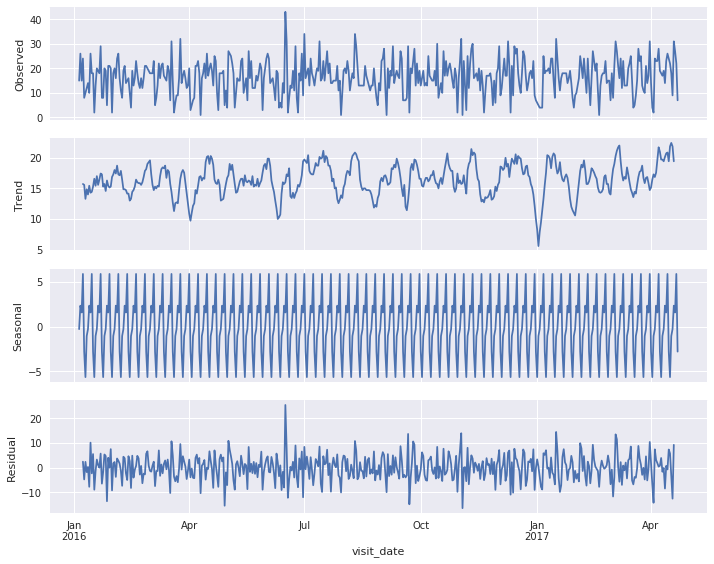

In [27]:
# plot decomposition time-series
print("plot for restaurant with id %s" % random_air_id)
trend, seasonal, residual = decomposition(random_restaurant, model='additive')

The first step in fitting ARIMA model is the determination of the order of differencing(d) needed to stationarize the series. for the nonseasonal part, we see that the ACF plot (Figure 1) already showing no correlation between lag. Also there is a seasonal component at the lag 7 (spikes at lag 7). It means that this series contains seasonal component, which is we have to search seasonal parameters also.

If the lag-1 autocorrelation is zero or even negative, then the series does not need further differencing. This means, that the data already stationary and we use 0 for differencing parameter.

After a time series has been stationarized, the second step is to determine MA(q) and AR(p) values by looking at the ACF and PACF plot of the differenced series (Figure 1). Because PACF is exponentially decaysing and there is a significant spike at lag-1 in ACF, it means that we don't need to add AR component only MA component. So for nonseasonal part we use (0, 0, 1) parameters.

#### No differencing plot

plot for restaurant with id ['air_81a12d67c22e012f']


(<matplotlib.axes._subplots.AxesSubplot at 0x7f99326c0fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99324c17d0>)

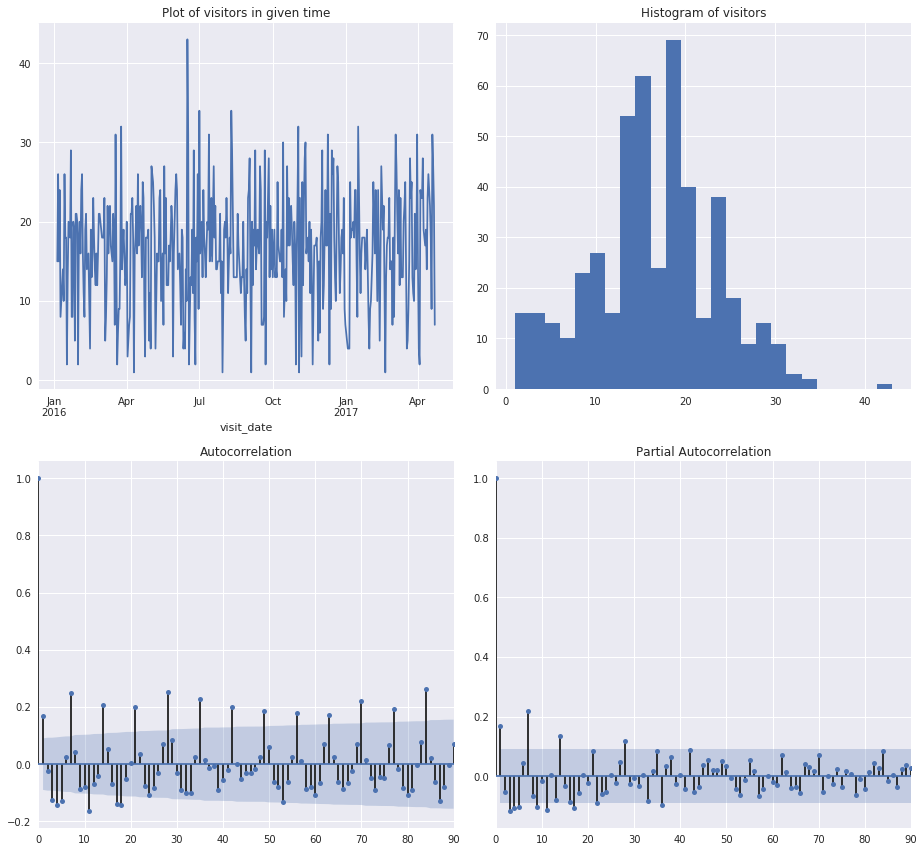

In [28]:
# plot ACF and PACF
print("plot for restaurant with id %s" % random_air_id)
tsplot(random_restaurant, lags=90, figsize=(13, 12))

Plot Seasonal differencing order for restaurant with id ['air_81a12d67c22e012f']


(<matplotlib.axes._subplots.AxesSubplot at 0x7f993bfb9490>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f993806a1d0>)

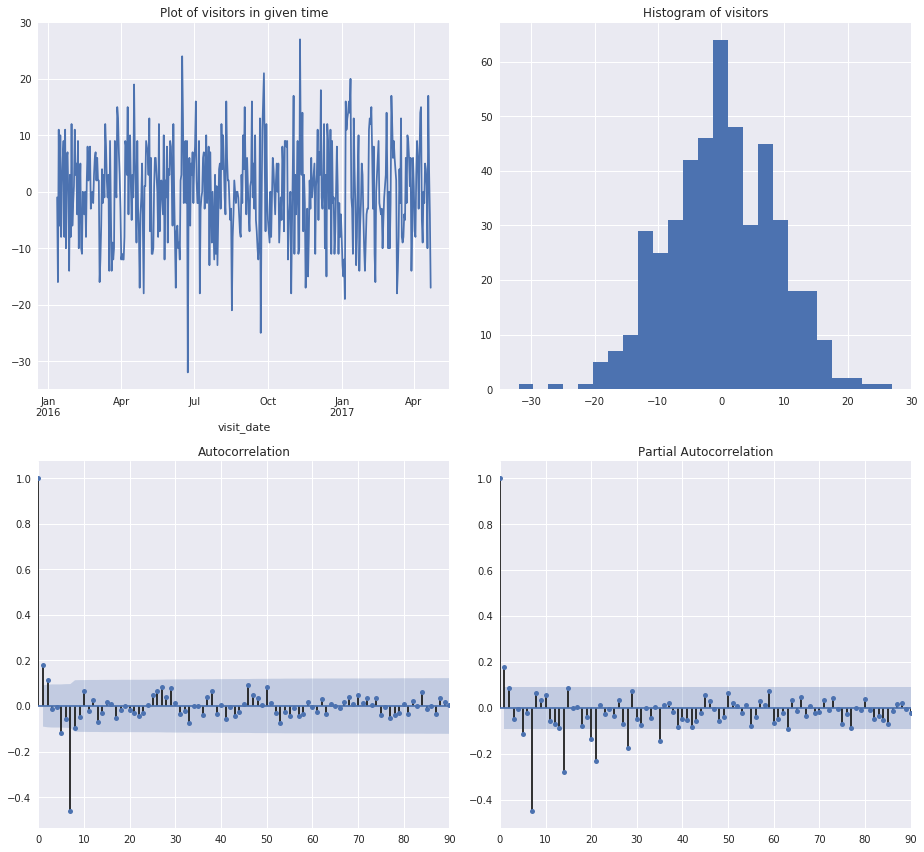

In [29]:
# plot ACF and PACF
n_order = 7
print("Plot Seasonal differencing order for restaurant with id %s" % random_air_id)
tsplot(random_restaurant.diff(n_order)[n_order:], lags=90, figsize=(13, 12))

#### SARIMAX model

ARIMA model including eXogenous covariates, ARIMAX extends the ARIMAX. The model will including the linear effects of one or more exe\ogenous series. We also can use this with seasonal ARIMA model, become SARIMAX. The *holidays* and *mean_reserve_visitors* columns can be assed to the X of SARIMAX as eXogenous covariates. Because we know that *mean_reserve_visitors* only correlated when holiday, the effect won't be significant. So we only includes *holidays* column as eXogenous variables.

In [198]:
holiday_df = data['date_info'].copy(deep=True)
holiday_df['visit_date'] = pd.to_datetime(holiday_df['calendar_date'])
holiday_df = holiday_df.set_index('visit_date')
train_exog_df = holiday_df.loc[min(random_restaurant_train.index):max(random_restaurant_train.index)]['holiday_flg']

test_exog_df = holiday_df.loc[date_test[:-1]]['holiday_flg']
test_exog_df = test_exog_df.reshape(len(test_exog_df), 1)

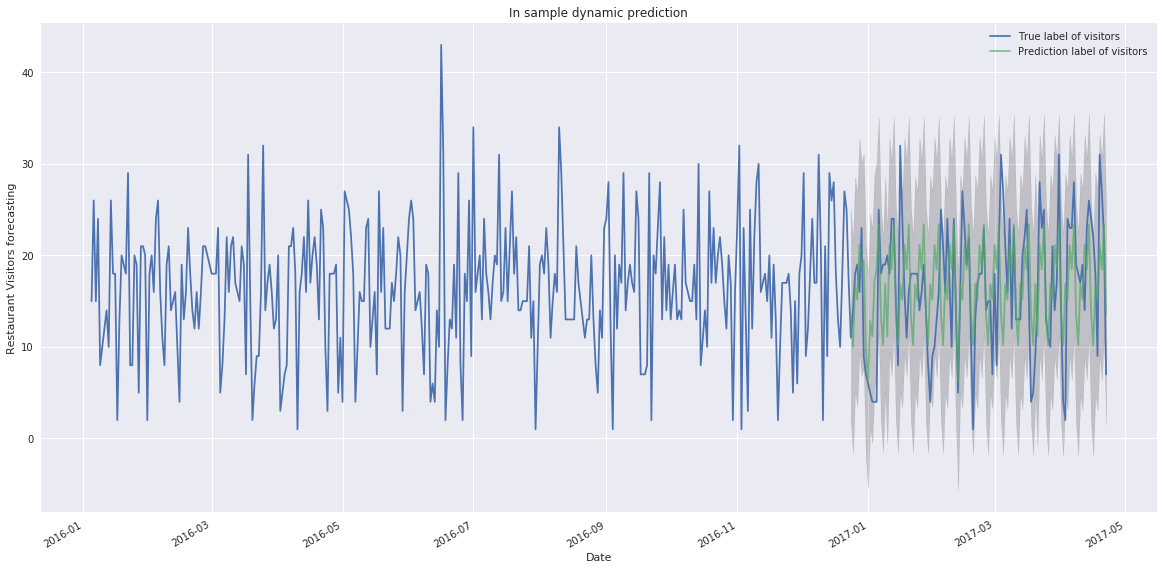

In [199]:
# fitting the manually processed
test_date_start = min(date_test)
test_date_end = max(date_test)

man_results = arima_fit(random_restaurant_train, (0, 0, 1), (0, 1, 1, 7), exog=train_exog_df)
# prediction
man_pred = man_results.get_prediction(start=test_date_start, end=test_date_end, dynamic=False, exog=test_exog_df)
man_pred_ci = man_pred.conf_int()
prediction_plot(man_pred.predicted_mean, man_pred_ci, random_restaurant, figsize=(20,10))

In order to fit the time series data with seasonal ARIMA model, we need to find the values of ARIMA(p, d, q)(P, D, Q)s. We can try to choose the values by manual process, but it requires expertise and time consuming. Like supervised-learning, we can try technique "grid search" where we iteratively try the combination of parameters by minimizing AIC or BIC score. The parameters with best score can be stated as optimal parameters.

In [140]:
def arima_grid_search(y, trend=None, exog=None, param_min=0, param_max=2, seasonal=7):
    ''' 
    Akaike's Information Criterion (AIC), is useful to determine the order of an ARIMA model
    ARIMA grid search will search the best parameters which obtained by minimizing the AIC values.
    '''
    best_param = {
        'param': None,
        'param_seasonal': None,
        'score': 1000000000,
        'results': None
    }
    # Define the p, d and q parameters to take any value between min and max
    p = d = q = range(param_min, param_max+1)    
    pdq = list(itertools.product(p, d, q))
    
    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                if '{}x{}'.format(param, param_seasonal) in param_error:
                    continue
                results = arima_fit(y, param, param_seasonal, trend=trend, exog=exog)
                if best_param['score'] > results.aic:
                    best_param['param'] = param
                    best_param['param_seasonal'] = param_seasonal
                    best_param['score'] = results.aic
                    best_param['results'] = results
                    logging.info('SARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
            except:
                print('SARIMA{}x{} is error'.format(param, param_seasonal))
                continue
    
    return best_param


best_param = arima_grid_search(
    random_restaurant_train, 
    exog=train_exog_df,
    param_max=2
)

print(best_param)
print(best_param['results'].summary().tables[1])

2018-03-07 12:18:52,594 - INFO - SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC: 2765.7711383
2018-03-07 12:18:52,970 - INFO - SARIMA(0, 0, 0)x(0, 0, 2, 7) - AIC: 2595.16195463
2018-03-07 12:18:53,259 - INFO - SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC: 2192.14095841
2018-03-07 12:18:53,841 - INFO - SARIMA(0, 0, 0)x(0, 1, 2, 7) - AIC: 2154.82503441
2018-03-07 12:18:56,679 - INFO - SARIMA(0, 0, 0)x(0, 2, 2, 7) - AIC: 2153.9473718
2018-03-07 12:18:59,980 - INFO - SARIMA(0, 0, 0)x(1, 1, 2, 7) - AIC: 2152.71738791
2018-03-07 12:19:15,700 - INFO - SARIMA(0, 0, 1)x(0, 1, 2, 7) - AIC: 2144.16293197
2018-03-07 12:19:19,637 - INFO - SARIMA(0, 0, 1)x(0, 2, 2, 7) - AIC: 2141.73823529
2018-03-07 12:19:44,775 - INFO - SARIMA(0, 0, 2)x(0, 1, 2, 7) - AIC: 2139.14384031
2018-03-07 12:19:50,311 - INFO - SARIMA(0, 0, 2)x(0, 2, 2, 7) - AIC: 2138.09423693


{'param_seasonal': (0, 2, 2, 7), 'score': 2138.0942369287832, 'results': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f03befff510>, 'param': (0, 0, 2)}
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
holiday_flg    -4.2133      1.118     -3.768      0.000      -6.405      -2.022
ma.L1           0.1272      0.059      2.158      0.031       0.012       0.243
ma.L2           0.0362      0.056      0.644      0.519      -0.074       0.146
ma.S.L7        -1.9181      0.079    -24.321      0.000      -2.073      -1.764
ma.S.L14        0.9225      0.069     13.444      0.000       0.788       1.057
sigma2         36.1374      4.390      8.232      0.000      27.534      44.741


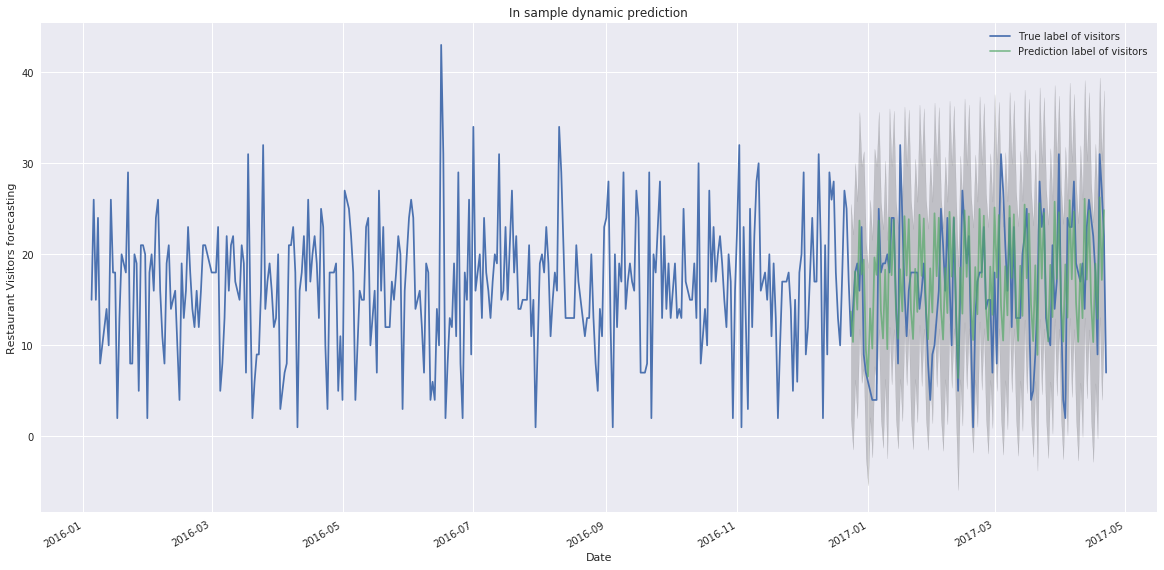

In [141]:
# Fitting the ARIMA Grid search
grid_pred = best_param['results'].get_prediction(start=test_date_start, end=test_date_end, dynamic=False, exog=test_exog_df)
pred_ci = grid_pred.conf_int()
prediction_plot(grid_pred.predicted_mean, pred_ci, random_restaurant, figsize=(20,10))

In [200]:
# calculate RMSLE error
print('RMSLE Error for ARIMA grid search model on random restaurant', score_rmsle(random_restaurant_test, grid_pred.predicted_mean))
print('RMSLE Error for ARIMA grid manual model on random restaurant', score_rmsle(random_restaurant_test, man_pred.predicted_mean))

('RMSLE Error for ARIMA grid search model on random restaurant', 0.50746536839273093)
('RMSLE Error for ARIMA grid manual model on random restaurant', 0.48495271658927402)


Because manual analysis method is better than grid search, we may use this parameter for all of restaurants on test dataset (faster than search the suitable parameter for every restaurant).

In [257]:
test_date_start = min(date_test)
test_date_end = max(date_test)


def predict_multiple_restaurants(air_store_id, test_date_start, test_date_end):
    pred_df_ = pd.DataFrame(columns=['air_store_id', 'visit_date', 'pred_visitors'])
    pred_df = pred_df_.fillna(0)
    count = 0
    fail_air_store_id = []
    for i in air_store_id:
        count += 1
        air_store_filter = filter_store_id(data['air_visit_data'], 'air_store_id', [i])
        air_store_filter = reindex_time(air_store_filter)
        train_air_store_filter = air_store_filter.loc[:max(random_restaurant_train.index)]
#         print(count)
        if train_air_store_filter.empty is True:
            continue
        # adding exog variable
        train_exog_df = holiday_df.loc[min(train_air_store_filter.index):max(train_air_store_filter.index)]['holiday_flg']
        test_exog_df = holiday_df.loc[date_test[:-1]]['holiday_flg']
        test_exog_df = test_exog_df.reshape(len(test_exog_df), 1)
        try:
            results= arima_fit(train_air_store_filter['visitors'], (0, 0, 1), (0, 1, 1, 7), exog=train_exog_df)
            prediction = results.get_prediction(start=test_date_start, end=test_date_end, dynamic=False, exog=test_exog_df)
            pred_data = {
                'visit_date': list(pd.date_range(test_date_start, test_date_end)),
                'air_store_id': [i for x in range(0, len(prediction.predicted_mean))],
                'pred_visitors': list(prediction.predicted_mean),
            }
            dummy_df = pd.DataFrame(pred_data)
            pred_df = pd.concat([pred_df, dummy_df])
        except ValueError:  # there are some id that return error, because of data is to small to be fitted
            fail_air_store_id.append(i)
            continue
    return pred_df, fail_air_store_id

pred_df, fail_air_store_id = predict_multiple_restaurants(air_visit_id, test_date_start, test_date_end)

In [258]:
print("failed predicted air_store_id : %s" % fail_air_store_id)

failed predicted air_store_id : ['air_7420042ff75f9aca', 'air_2703dcb33192b181', 'air_cb083b4789a8d3a2', 'air_31c753b48a657b6c']


In [259]:
X_test = data['air_visit_data'][(data['air_visit_data']['visit_date'] >= '2016-12-24') & (data['air_visit_data']['visit_date'] <= '2017-04-22')]
X_test['visit_date'] = pd.to_datetime(X_test['visit_date'])
X_test = X_test.merge(pred_df, on=['air_store_id', 'visit_date'])
print('RMSLE Error using ARIMA model', score_rmsle(X_test['visitors'], X_test['pred_visitors']))

('RMSLE Error using ARIMA model', 0.59808641159372899)


### Machine Learning Approach

With Machine Learning approach, create a model is much faster than statistical approach (need to search for different parameters for every restaurant). Also if we considering features that have non-seasonal and non-trend, a statistical approach is harder to use. To include seasonal factors, we can add time-related features to the models by creating dummy variables. Because we know that the series have weekly, monthly and holidays effects, we might add these factors as dummy variables. By using this approach we are assuming the seasonal patterns is deterministic, means it does not change over time.

Most ML Algorithms do not work with categorical variable, they require all input and output to be numeric. So in order to create dummy variables that can be used in ML Algorithm, we need to encode the data to turn a categorical variable into a numerical variable. There are two standard methods for encoding the data that is Label Encoding and One-Hot Encoding. There us much debates on when we prefer to use one method over another. There are several points to consider:

* **Label Encoding**: Give numerical values to different classes. Usually used when data have ordinal relationship or the data have to be ordered because there are relations between them.
* **One-Hot Encoding**: When the data has no ordinal relationship, label encoding can't be used because it can be lead to poor performance so One-Hot Encoding is better choice. One-Hot Encoding will create sparse matrix where one categoric value represented as one column. When they are only two categoric value, Label Encoding is preferable. If they have many categoric values, One-Hot Encoding can create Curse of Dimensionality so we need to be careful when using it.

Because of that reason, we use Label Encoding in Prefecture, City and Restaurant genre and One-Hot Encoding in Week, Month, and Holiday.

In [20]:
def parse_area(areaname):
    ''' parse area into : prefecture, city, area format '''
    area_split = areaname.split(' ')    
    prefect = area_split[0]
    city = area_split[1]
    area = ' '.join(area_split[2:])
    return prefect, city, area

# Feature Engineering
air_restaurant_genre = data['air_store_info'].copy(deep=True)
air_restaurant_genre['prefecture'] = data['air_store_info']['air_area_name'].apply(lambda row: parse_area(row)[0])
air_restaurant_genre['city'] = data['air_store_info']['air_area_name'].apply(lambda row: parse_area(row)[1])
air_restaurant_genre['area'] = data['air_store_info']['air_area_name'].apply(lambda row: parse_area(row)[2])
air_restaurant_genre_full = data['air_visit_data'].merge(air_restaurant_genre, how='outer')

# join the mean of visitors and mean of reservation visitors
air_restaurant_genre_full = air_restaurant_genre_full.merge(air_visit_reserve_mean, how='outer', on='visit_date')

#join the holiday dataframe
data['date_info'].columns = ['visit_date', 'days_of_week', 'holiday_flg']
air_restaurant_full = air_restaurant_genre_full.merge(data['date_info'], how='left')

In [274]:
from sklearn.preprocessing import LabelEncoder

# Encoding
store_label = LabelEncoder()
air_restaurant_full['air_store_label'] = store_label.fit_transform(air_restaurant_full['air_store_id'])
air_restaurant_full['month'] = pd.to_datetime(air_restaurant_full['visit_date']).dt.month
air_restaurant_full['weekday'] = pd.to_datetime(air_restaurant_full['visit_date']).dt.weekday
air_restaurant_full['visit_timestamp'] = pd.to_datetime(air_restaurant_full['visit_date']).apply(lambda x: x.strftime('%Y%m%d')).astype(int)

# weekday_data = pd.get_dummies(air_restaurant_full['days_of_week'], prefix='weekday')
genre_data = pd.get_dummies(air_restaurant_full['air_genre_name'], prefix='genre')
prefecture_data = pd.get_dummies(air_restaurant_full['prefecture'], prefix='prefecture')
city_data = pd.get_dummies(air_restaurant_full['city'], prefix='city')

final_df = pd.concat([air_restaurant_full, genre_data, prefecture_data, city_data], axis=1)

# drop unnecessary column
drop_col = ['mean_visitors', 'mean_reserve_visitors','air_store_id', 'air_genre_name', 'air_area_name', 'city', 'area', 'prefecture', 'days_of_week', 'latitude', 'longitude']
final_df = final_df.drop(drop_col, axis=1)

# train test split for regression model
X_train = final_df[final_df['visit_date'] < '2016-12-24']
X_test = final_df[(final_df['visit_date'] >= '2016-12-24') & (final_df['visit_date'] <= '2017-04-22')]

y_train = X_train['visitors']
y_test = X_test['visitors']

X_train.drop(['visit_date', 'visitors'], axis=1, inplace=True)
X_test.drop(['visit_date', 'visitors'], axis=1, inplace=True)

In [276]:
X_test.head(10)

,holiday_flg,air_store_label,month,weekday,visit_timestamp,genre_Asian,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,...,city_Shizuoka-shi,city_Suginami-ku,city_Suita-shi,city_Tachikawa-shi,city_Taitō-ku,city_Takarazuka-shi,city_Toshima-ku,city_Yame-shi,city_Ōsaka-shi,city_Ōta-ku
143565,0,603,12,5,20161224,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
143566,0,106,12,5,20161224,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143567,0,446,12,5,20161224,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
143568,0,157,12,5,20161224,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
143569,0,535,12,5,20161224,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143570,0,312,12,5,20161224,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
143571,0,676,12,5,20161224,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
143572,0,795,12,5,20161224,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143573,0,408,12,5,20161224,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
143574,0,504,12,5,20161224,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Model Fit

In [27]:
import time
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor, use as benchmark model
start_time = time.time()
rs = 101  # random seed

rf_regr = RandomForestRegressor(
    random_state=rs,
    n_estimators=10, 
    criterion='mse', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='auto'
)
rf_regr.fit(X_train, y_train)
rf_prediction = rf_regr.predict(X_test)
print('Running time model: {}'.format(time.time() - start_time))
print('Benchmark: untuned Random Forest model in train data', score_rmsle(rf_regr.predict(X_train), y_train))
print('Benchmark: untuned Random Forest model in test data', score_rmsle(y_test, rf_prediction))

Running time model: 13.062267065
('Benchmark: untuned Random Forest model in train data', 0.27467343921698106)
('Benchmark: untuned Random Forest model in test data', 0.78718391771941099)


XGBoost is usually used to dominate machine learning competition on Kaggle due its scalability, speed and predictive power. Usually many practicioner use XGBoost as black box thus we not use all of the advantages of it. In order to reached better accuracy and get the optimal performance, the algorithm needs to be tuned. The parameters that we should understand are:

* `n_estimators`: Number of boosted trees to fit. 
* `early_stopping_rounds`: Find a way to automatically find the ideal value by stopping iterate when the validation score stops improving (deteriorating) after n straight rounds. The better ways to use it, is by setting higher value of `n_estimators` and use `early_stopping_rounds` to stop iteration.
* `learning_rate` or `eta`: multiply each updates of predictions by n value before adding them in. In general, small learning rate will yield accurate models even though it does create more iteration.
* `n_jobs`: When use larger dataset, runtime of creating model is crucial. This will create parallelism to build our model faster.
* There are several parameters that can used to control model complexity: 
    * `max_depth`: Maximum depth of a tree, increasing this value will make model more complex and prone to overfitting.
    * `min_child_weight`: Regularization parameter, minimum sum of instance of weight needed in a child.    
* To add randomness to make training robust to noise: 
    * `subsample`: subsample ratio of training examples per tree
    * `colsample_bytree`: subsample ratio of columns when constructing each tree.
    
There are two form of XGBoost:

* `xgb`: XGBoost direct core library, use `DMatrix` as internal data structure which optimized for both memory efficiency and training speed.
* `XGBRegressor`: Sklearn wrapper for XGBoost library. This allow us to use syntax as sklearn and sklearn's Grid Search method with parallel processing in the same way as xgb did.

I choose relatively small `learning_rate`, 0.1. Generally a learning rate that can works is between 0.05 and 0.3, so i choose number between these. We can use high `n_estimator`, the cross-validation and `early_stopping_rounds` will taken care of this problems. There are many tree-specific that we can tuned, we will use Grid Search method to get the best hyper-parameters. We also can tuned the *regularization parameters* like `lambda` and `alpha` to reduce the model complexity and enhance performance.

In [293]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

# eval metrcis
def rmsle_eval(y, y0):    
    y0 = y0.get_label()    
    assert len(y) == len(y0)
    return 'rmsle', score_rmsle(y, y0)

def xboost_fit(regr, early_stopping_rounds=10):
    start_time = time.time()

    xgb_param = regr.get_xgb_params()
    dtrain = xgb.DMatrix(X_train, y_train)

    cvresult = xgb.cv(
                    xgb_param, dtrain,
                    num_boost_round=xgb_regr.get_params()['n_estimators'], 
                    nfold=3,
                    feval=rmsle_eval,
                    early_stopping_rounds=early_stopping_rounds
                )
    xgb_regr.set_params(n_estimators=cvresult.shape[0])
    xgb_regr.fit(X_train, y_train, eval_metric=rmsle_eval)

    print('Running time model: {}'.format(time.time() - start_time))
    print('CV train XGBoost model:', cvresult.iloc[-1,:]['train-rmsle-mean'])
    print('CV test XGBoost model', cvresult.iloc[-1,:]['test-rmsle-mean'])
    return xgb_regr

In [307]:
xgb_regr = XGBRegressor(
            learning_rate=0.1, n_estimators=100, 
            objective='reg:linear', seed=0, colsample_bytree=0.9,
            subsample=0.5, max_depth=6, min_child_weight=2
            )

dtest = xgb.DMatrix(X_test)
fitted_model = xboost_fit(xgb_regr, early_stopping_rounds=10)
dtrain_predictions = fitted_model.predict(X_test)
print("RMSLE test error for XGBoost model: %s" % score_rmsle(y_test, dtrain_predictions))

Running time model: 8111.46913218
('CV train XGBoost model:', 0.74364099999999989)
('CV test XGBoost model', 0.74501499999999998)
RMSLE test error for XGBoost model: 0.770116353362


In [302]:
# Using Grid Search to get optimized parameter
# custom scorer
rmsle_ = make_scorer(score_rmsle, greater_is_better=False)

grid_param = {
 'max_depth':[4, 6, 8, 10, 12],
 'min_child_weight':[4, 5, 6, 8]
}
xgb_regr = XGBRegressor(
            learning_rate=0.1, n_estimators=100, 
            objective='reg:linear', seed=0, colsample_bytree=0.9,
            subsample=0.5, max_depth=12, min_child_weight=4
            )

gsearch = GridSearchCV(xgb_regr, param_grid = grid_param, scoring=rmsle_, n_jobs=4, iid=False, cv=3)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=4, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 6, 8, 10, 12], 'min_child_weight': [4, 5, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(score_rmsle, greater_is_better=False),
       verbose=0)

In [303]:
gsearch.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

In [304]:
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.76107, std: 0.02609, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.75978, std: 0.02730, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.76017, std: 0.02739, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.76032, std: 0.02687, params: {'max_depth': 4, 'min_child_weight': 8},
  mean: -0.71973, std: 0.02534, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.71744, std: 0.02313, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.72151, std: 0.02503, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -0.71858, std: 0.02361, params: {'max_depth': 6, 'min_child_weight': 8},
  mean: -0.67636, std: 0.02329, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: -0.67572, std: 0.02035, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -0.67800, std: 0.02517, params: {'max_depth': 8, 'min_child_weight': 6},
  mean: -0.67543, std: 0.02487, params: {'max_depth': 8, 'min_child_weight': 8},
  mean: -0.64095, std: 0.018

In [308]:
xgb_regr = XGBRegressor(
            learning_rate=0.1, n_estimators=100, 
            objective='reg:linear', seed=0, colsample_bytree=0.9,
            subsample=0.5, max_depth=12, min_child_weight=5
            )

dtest = xgb.DMatrix(X_test)
fitted_model = xboost_fit(xgb_regr, early_stopping_rounds=10)
dtrain_predictions = fitted_model.predict(X_test)
print("RMSLE test error for XGBoost model: %s" % score_rmsle(y_test, dtrain_predictions))

Running time model: 8208.92011619
('CV train XGBoost model:', 0.66248933333333326)
('CV test XGBoost model', 0.67394366666666672)
RMSLE test error for XGBoost model: 0.745983922272


In [309]:
grid_param = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'gamma':[0, 0.1, 0.2, 0.3, 0.4]
}
xgb_regr = XGBRegressor(
            learning_rate=0.1, n_estimators=100, 
            objective='reg:linear', seed=0, colsample_bytree=0.9,
            subsample=0.5, max_depth=12, min_child_weight=5
            )

gsearch = GridSearchCV(xgb_regr, param_grid = grid_param, scoring=rmsle_, n_jobs=4, iid=False, cv=3)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05], 'gamma': [0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(score_rmsle, greater_is_better=False),
       verbose=0)

In [310]:
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.61581, std: 0.02032, params: {'reg_alpha': 0, 'gamma': 0},
  mean: -0.61625, std: 0.01952, params: {'reg_alpha': 0.001, 'gamma': 0},
  mean: -0.61584, std: 0.02197, params: {'reg_alpha': 0.005, 'gamma': 0},
  mean: -0.61792, std: 0.01991, params: {'reg_alpha': 0.01, 'gamma': 0},
  mean: -0.61629, std: 0.02469, params: {'reg_alpha': 0.05, 'gamma': 0},
  mean: -0.61708, std: 0.02044, params: {'reg_alpha': 0, 'gamma': 0.1},
  mean: -0.61554, std: 0.02167, params: {'reg_alpha': 0.001, 'gamma': 0.1},
  mean: -0.61686, std: 0.02224, params: {'reg_alpha': 0.005, 'gamma': 0.1},
  mean: -0.61351, std: 0.02010, params: {'reg_alpha': 0.01, 'gamma': 0.1},
  mean: -0.61810, std: 0.02231, params: {'reg_alpha': 0.05, 'gamma': 0.1},
  mean: -0.61612, std: 0.02004, params: {'reg_alpha': 0, 'gamma': 0.2},
  mean: -0.61601, std: 0.02013, params: {'reg_alpha': 0.001, 'gamma': 0.2},
  mean: -0.61636, std: 0.01824, params: {'reg_alpha': 0.005, 'gamma': 0.2},
  mean: -0.61816, std: 0.02123, params

In [311]:
xgb_regr = XGBRegressor(
            learning_rate=0.1, n_estimators=100, 
            objective='reg:linear', seed=0, colsample_bytree=0.9,
            subsample=0.5, max_depth=12, min_child_weight=5,
            gamma=0.1, reg_alpha=0.01
            )

dtest = xgb.DMatrix(X_test)
fitted_model = xboost_fit(xgb_regr, early_stopping_rounds=10)
dtrain_predictions = fitted_model.predict(X_test)
print("RMSLE test error for XGBoost model: %s" % score_rmsle(y_test, dtrain_predictions))

Running time model: 12109.399251
('CV train XGBoost model:', 0.66183466666666668)
('CV test XGBoost model', 0.67322399999999993)
RMSLE test error for XGBoost model: 0.74126733071


## Result

### Evaluation Metrics

The benchmark we are going to use is untuned Random Forest model, that is RMSLE= '0.787'. This score is easy to beat because untuned Random Forest tends to overfit the training data.

In Table 1, we can clearly see the result for both approaches. By using only historical and holidays, ARIMA can capture better for forecasting visitors rather than Machine Learning approaches. The XGBoost model is quite close to the benchmark model. So even we tuned the hyper-parameters, the score only increase slightly. Thus we need more features that can explained the visitation data rather than tune the model.

| Approach  |  Algorithm | RMSLE  |
|---|---|---|
| Benchmark  | Random Forest  | 0.787  |
| Statistical  | SARIMAX  |  0.598 |
| ML  | XGBoost  | 0.7412 |

It is not a standard to train ARIMA model over multiple time series with same parameters. Different restaurant generated different time series thus will have different parameters. By using grid search in ARIMA model, the model tends to overfits the training data. So to get more clear picture of the series, manual search is preferable.

## Conclusion

### Reflection
This project compares different approaches to solving restaurant forecasting. Analyzing the pros and cons each method and which is the best for this kind of problem. However, it was very difficult to decide because there are many other methods that can be used. Also, there are some variables that can be explored further and improved both methods accuracy. This suggests the need for more advanced approaches and exploring deeper dependent variables to make a better model that can understand customer behavior and make a better forecast.

### Challanges

To treat time-series into regression problem can be painful. Because it is time-dependent and also have a form of seasonality and trends. It is not enough to capture it by using weekly, monthly and holiday pattern. There are many features that do not include in the models, like weathers, seasons, etc. Independent variables that have same affect for all restaurants is holidays while reservation data is not. So, we still haven't captured the correlation between reservation data and visitation. This will improve the score if we can use it.

To make better prediction by using regression, we can use Grid Search method. Unfortunately this requires substantial amount of resources. On my own PC, it takes about one to two hours to calculate one Grid Search. Because there are many hyper-parameters that can be tuned, it takes patience to get the best hyper-parameters. 

There are many another approach that can be used for this challenge, for example LSTM, Prophet and UCM. One of the method that many people recommend is LSTM (Long Short-Term Memory). LSTM Network is a RNN (Recurrent Neural Networks) that is trained using back propagation Through Time and overcomes the vanishing gradient problem. It can be used in Univariate and Multivariate Time Series forecasting problems. Having a few data, this will be another challenge to make the make a better model.


### Improvement

There is a lot of improvement in the future. I already have some in mind for this project:

* For data exploration, we need to explores the features that affect the visitor's behavior furtherer. We can use other data that available outside the challenges like weather and seasons data.
* To get the best of XGBoost model, hyperparameter tuning is important to get maximum performance. `GridSearchCV` in scikit-learn is the popular option for this. But outside scikit-learn, we can use `hyperopt` packages that eventually designed for model optimization.
* Most of kaggle competition winners used well-tuned of many models to get a better prediction. We can implement ensemble technique to improve the predictive performance. Ensemble technique uses a new model that combined the predictions from two or more models that already been trained on train dataset. There are many types of ensembles, we can use averaging of predictions or even weighted averaging from multiple models to get better accuracy.